# Stock price forecasting using neural networks 

In this notebook, we will use a recurrent neural network set up for time series forecasting to predict the closing price of the Apple stock, given the previous 40 days as the input.  

## 1. Get data and preprocess it for the network 

In [130]:
import yfinance as yf
apple_price = yf.Ticker("AAPL")
ap_history = apple_price.history(period="max") 
ap_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.100178,0.100614,0.100178,0.100178,469033600,0.0,0.0
1980-12-15,0.095388,0.095388,0.094952,0.094952,175884800,0.0,0.0
1980-12-16,0.088418,0.088418,0.087983,0.087983,105728000,0.0,0.0
1980-12-17,0.090160,0.090596,0.090160,0.090160,86441600,0.0,0.0
1980-12-18,0.092774,0.093210,0.092774,0.092774,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2022-07-14,144.080002,148.949997,143.250000,148.470001,78140700,0.0,0.0
2022-07-15,149.779999,150.860001,148.199997,150.169998,76030800,0.0,0.0
2022-07-18,150.740005,151.570007,146.699997,147.070007,81420900,0.0,0.0


In [131]:
ap_close_prices = list(ap_history['Close'])

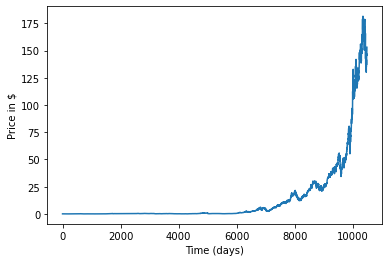

In [132]:
import matplotlib.pyplot as plt
plt.plot(ap_close_prices)
plt.ylabel('Price in $')
plt.xlabel('Time (days)')
plt.show()

View the first 5 and last 5 prices: 

In [133]:
ap_close_prices[:5], ap_close_prices[-5:]

([0.10017841309309006,
  0.0949520617723465,
  0.08798282593488693,
  0.09016044437885284,
  0.0927744135260582],
 [148.47000122070312,
  150.1699981689453,
  147.07000732421875,
  151.0,
  153.0399932861328])

We need to normalize this data such that each value is between 0 and 1. Note: the normalization and time series data processing portion of the following code was inspired by/adapted from [this](https://www.youtube.com/watch?v=PuZY9q-aKLw&t=800s&ab_channel=NeuralNine) tutorial. 

In [134]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(np.array(ap_close_prices).reshape(-1, 1))

In [135]:
scaled_dataset[5]

array([0.00033122])

We can get the original stock price back to calling `inverse_transform`: 

In [136]:
scaler.inverse_transform(np.array(scaled_dataset[5]).reshape(-1, 1))

array([[0.09843633]])

We can now build the dataset consisting of `(x,y)` samples: 

In [137]:
NUM_DAYS = 40
x_train = []
y_train = []

for i in range(NUM_DAYS, len(scaled_dataset)):
    x_window = scaled_dataset[i - NUM_DAYS:i, 0]
    y_window = scaled_dataset[i, 0]
    x_train.append(x_window)
    y_train.append(y_window)

In [138]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [139]:
dataset = list(zip(x_train, y_train))

In [140]:
dataset = np.array(dataset)

<ipython-input-140-ef7e17a7bc77>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)


In [141]:
dataset.shape

(10449, 2)

Create the `DataSet` and `DataLoader`: 

In [142]:
from torch.utils.data import Dataset, TensorDataset

class GetDataset(Dataset):
    def __init__(self, data_set): # x and y are stored in tuples in data_set (np array)
        self.data_distribution = data_set
    
    def __getitem__(self, index):
        x = self.data_distribution[index][0]
        y = self.data_distribution[index][1]
        
        return (torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)) 
    
    def __len__(self):
        return len(self.data_distribution)

In [143]:
torch_set = GetDataset(dataset)

In [144]:
import torch
TRAIN_RATIO = 0.80  # 80/20 split 
train_size = int(TRAIN_RATIO * len(torch_set))  
test_size = len(torch_set) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(torch_set, [train_size, test_size])

In [145]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1) 
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [148]:
print("Train set length: ", len(trainloader))
print("Test set length: ", len(testloader))

Train set length:  8359
Test set length:  2090


## 2. Build the neural network 

The following network code was inspired by the official documentation for the LSTM layer ([link](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)) and [this](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/#step-3-create-model-class) blog post. 

In [161]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        # instance variables 
        self.hidden_dim = 20
        self.num_layers = 2

        self.lstm_layer = nn.LSTM(1, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # note: x.size(0) gets batch size 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm_layer(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        return torch.flatten(out)

In [162]:
model = LSTM()

In [163]:
for batch in trainloader:
    x, y = batch 
    x = x.reshape(1,x.shape[-1],1)
    print(torch.flatten(model(x)).shape)
    print(x.shape)
    break

torch.Size([1])
torch.Size([1, 40, 1])


## 3. Train 

In [164]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [166]:
from tqdm.auto import tqdm
EPOCHS = 5  # num epochs 
epoch_num = 0
loss_vals = []

for epoch in range(EPOCHS):  # loop over the dataset (EPOCHS) times 
    epoch_num += 1
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(trainloader, 0)):
        x = data[0]  
        y = data[1] 
        
        x = x.reshape(1, x.shape[-1], 1)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(x) 
        outputs = torch.flatten(outputs)
        loss = criterion(outputs, y) 
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 

    print("Loss for epoch " + str(epoch_num) + ":", running_loss)
    loss_vals.append(running_loss)
    
print('Finished Training')


Loss for epoch 1: 15.496617746212154



Loss for epoch 2: 2.8346715826318687



Loss for epoch 3: 2.111023542104845



Loss for epoch 4: 1.5691732307041584



Loss for epoch 5: 1.5974390855005027
Finished Training


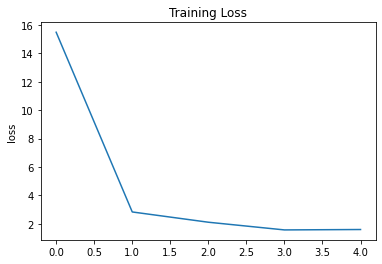

In [167]:
# graph the model's training loss 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

plt.plot(loss_vals)
plt.title('Training Loss')
plt.ylabel('loss')
plt.show()

## 4. Evaluate the model on the test set 

In [172]:
test_losses = []
for batch in testloader:
    x, y = batch
    x = x.reshape(1, x.shape[-1], 1)
    out = model(x)
    loss_value = criterion(out, y).item()
    test_losses.append(loss_value)

print("Average test loss: ", sum(test_losses)/len(test_losses))

Average test loss:  5.087201608153921e-05
